   #                           Insurance Service Payment Call Prediction

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import re
import random
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV, LassoCV
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Load Dataset

In [2]:
df_raw = pd.read_csv('insurance.csv')
df_raw.head()

,DATE_FOR,RTD_ST_CD,CustomerSegment,Tenure,Age,MART_STATUS,GENDER,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,...,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,NOT_DI_3M,NOT_DI_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
0,5/19/2014,ST_S0,1,16.175222,78.403833,MS_S0,F,0.0,0.0,1.0,...,2,0,3,0,0,0,0,0,0,0
1,5/17/2014,ST_S0,1,15.931554,70.989733,MS_S1,F,0.0,6.0,0.0,...,0,3,3,0,0,0,0,0,0,0
2,5/15/2014,ST_S0,1,15.937029,87.578371,MS_S2,M,0.0,0.0,10.0,...,0,0,6,0,0,0,0,0,0,0
3,5/16/2014,ST_S1,1,15.934292,68.438056,MS_S2,M,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0
4,5/20/2014,ST_S0,1,15.501711,80.514716,MS_S0,F,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0


Investigate data shape, data types.

In [3]:
print("Data Shape:", df_raw.shape)
print("Data Dtypes:\n", df_raw.dtypes)

Data Shape: (130086, 29)
Data Dtypes:
 DATE_FOR                  object
RTD_ST_CD                 object
CustomerSegment           object
Tenure                   float64
Age                      float64
MART_STATUS               object
GENDER                    object
CHANNEL1_6M              float64
CHANNEL2_6M              float64
CHANNEL3_6M              float64
CHANNEL4_6M              float64
CHANNEL5_6M              float64
METHOD1_6M               float64
RECENT_PAYMENT           float64
PAYMENTS_6M              float64
CHANNEL1_3M                int64
CHANNEL2_3M                int64
CHANNEL3_3M                int64
CHANNEL4_3M                int64
CHANNEL5_3M                int64
METHOD1_3M                 int64
PAYMENTS_3M                int64
NOT_DI_3M                  int64
NOT_DI_6M                  int64
EVENT1_30_FLAG             int64
EVENT2_90_SUM              int64
LOGINS                     int64
POLICYPURCHASECHANNEL      int64
Call_Flag                  int64
dtyp

# EDA & Data Preprocessing

In [4]:
print("Missing Values:", df_raw.isnull().sum())

Missing Values: DATE_FOR                   0
RTD_ST_CD                  0
CustomerSegment            0
Tenure                     0
Age                        0
MART_STATUS                0
GENDER                     0
CHANNEL1_6M              809
CHANNEL2_6M              809
CHANNEL3_6M              809
CHANNEL4_6M              809
CHANNEL5_6M              809
METHOD1_6M               809
RECENT_PAYMENT           809
PAYMENTS_6M              809
CHANNEL1_3M                0
CHANNEL2_3M                0
CHANNEL3_3M                0
CHANNEL4_3M                0
CHANNEL5_3M                0
METHOD1_3M                 0
PAYMENTS_3M                0
NOT_DI_3M                  0
NOT_DI_6M                  0
EVENT1_30_FLAG             0
EVENT2_90_SUM              0
LOGINS                     0
POLICYPURCHASECHANNEL      0
Call_Flag                  0
dtype: int64


There are 809 missing values in data, which should be removed from the data set.

In [5]:
for var in df_raw:
    print(df_raw[var].unique().shape[0], "unique Values of", var, df_raw[var].unique(), "\n")

8 unique Values of DATE_FOR ['5/19/2014' '5/17/2014' '5/15/2014' '5/16/2014' '5/20/2014' '5/14/2014'
 '5/13/2014' '5/18/2014'] 

51 unique Values of RTD_ST_CD ['ST_S0' 'ST_S1' 'ST_S2' 'ST_S3' 'ST_S4' 'ST_S5' 'ST_S6' 'ST_S7' 'ST_S8'
 'ST_S9' 'ST_S10' 'ST_S11' 'ST_S12' 'ST_S13' 'ST_S14' 'ST_S15' 'ST_S16'
 'ST_S17' 'ST_S18' 'ST_S19' 'ST_S20' 'ST_S21' 'ST_S22' 'ST_S23' 'ST_S24'
 'ST_S25' 'ST_S26' 'ST_S27' 'ST_S28' 'ST_S29' 'ST_S30' 'ST_S31' 'ST_S32'
 'ST_S33' 'ST_S34' 'ST_S35' 'ST_S36' 'ST_S37' 'ST_S38' 'ST_S39' 'ST_S40'
 'ST_S41' 'ST_S42' 'ST_S43' 'ST_S44' 'ST_S45' 'ST_S46' 'ST_S47' 'ST_S48'
 'ST_S49' 'ST_S50'] 

4 unique Values of CustomerSegment ['1' '3' '2' 'NONE'] 

10228 unique Values of Tenure [16.175222 15.931554 15.937029 ...  0.049281  0.054757  0.046543] 

22347 unique Values of Age [78.403833 70.989733 87.578371 ... 91.895962 22.099932 21.489391] 

5 unique Values of MART_STATUS ['MS_S0' 'MS_S1' 'MS_S2' 'MS_S3' 'MS_S4'] 

2 unique Values of GENDER ['F' 'M'] 

14 unique Values o

In [6]:
df_raw.dropna(inplace=True)
df_raw.reset_index(drop=True, inplace=True)
print("Data Shape:", df_raw.shape)
df_raw.describe()

Data Shape: (129277, 29)


,Tenure,Age,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,CHANNEL4_6M,CHANNEL5_6M,METHOD1_6M,RECENT_PAYMENT,PAYMENTS_6M,...,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,NOT_DI_3M,NOT_DI_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
count,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,...,129277.000000,129277.000000,129277.000000,129277.000000,129277.000000,129277.0,129277.000000,129277.000000,129277.000000,129277.000000
mean,8.591581,48.813929,0.261810,0.948467,0.811652,0.401216,0.569823,1.834425,0.105680,4.848333,...,0.285333,0.914494,2.427145,0.056019,0.080502,0.0,0.193522,0.953774,0.131284,0.036549
std,7.297798,14.037131,1.092346,1.880123,1.824188,1.065413,1.628655,2.596754,0.307429,2.027548,...,0.850155,1.388627,1.211655,0.229960,0.272069,0.0,0.509437,2.149006,0.337712,0.187654
min,0.032854,16.689938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,3.252567,37.845311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,7.006160,49.111567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,11.630390,58.830938,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,6.000000,...,0.000000,2.000000,3.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
max,63.091034,99.348392,12.000000,53.000000,26.000000,18.000000,29.000000,53.000000,1.000000,53.000000,...,16.000000,36.000000,36.000000,1.000000,1.000000,0.0,4.000000,45.000000,1.000000,1.000000


In [7]:
# we find only CustomerSegment exists NONE after scanning all features
print(df_raw.groupby(['CustomerSegment']).count())

                 DATE_FOR  RTD_ST_CD  Tenure    Age  MART_STATUS  GENDER  \
CustomerSegment                                                            
1                   95349      95349   95349  95349        95349   95349   
2                   25226      25226   25226  25226        25226   25226   
3                    5019       5019    5019   5019         5019    5019   
NONE                 3683       3683    3683   3683         3683    3683   

                 CHANNEL1_6M  CHANNEL2_6M  CHANNEL3_6M  CHANNEL4_6M  ...  \
CustomerSegment                                                      ...   
1                      95349        95349        95349        95349  ...   
2                      25226        25226        25226        25226  ...   
3                       5019         5019         5019         5019  ...   
NONE                    3683         3683         3683         3683  ...   

                 CHANNEL5_3M  METHOD1_3M  PAYMENTS_3M  NOT_DI_3M  NOT_DI_6M  \
Custome

In [8]:
# replace NONE by 0
df_raw['CustomerSegment'] = [0 if x == 'NONE' else x for x in df_raw['CustomerSegment']]

In [9]:
# check and fill missing data
df_raw.isnull().any()
print(df_raw.isnull().sum())

DATE_FOR                 0
RTD_ST_CD                0
CustomerSegment          0
Tenure                   0
Age                      0
MART_STATUS              0
GENDER                   0
CHANNEL1_6M              0
CHANNEL2_6M              0
CHANNEL3_6M              0
CHANNEL4_6M              0
CHANNEL5_6M              0
METHOD1_6M               0
RECENT_PAYMENT           0
PAYMENTS_6M              0
CHANNEL1_3M              0
CHANNEL2_3M              0
CHANNEL3_3M              0
CHANNEL4_3M              0
CHANNEL5_3M              0
METHOD1_3M               0
PAYMENTS_3M              0
NOT_DI_3M                0
NOT_DI_6M                0
EVENT1_30_FLAG           0
EVENT2_90_SUM            0
LOGINS                   0
POLICYPURCHASECHANNEL    0
Call_Flag                0
dtype: int64


It demonstrates there are no missing values

# Convert non-numerical values to numerical

In [10]:
# DATE_FOR convert to mmddyyyy
token = [x.rstrip().split('/') for x in df_raw['DATE_FOR']]
df_raw['DATE_FOR'] = [x[0] + x[1] + x[2] for x in token]

In [11]:
# filter out substring
def filter_str_onDataFrame(df, colname, reg):
    result = []
    for line in df[colname]:
        x = re.findall(reg, line)
        result.append(''.join(x))
    df[colname] = result
    
# Due to all of the first four characters of RTD_ST_CD and MART_STATUS are same, so I suggest to strip off them.
filter_str_onDataFrame(df_raw, 'RTD_ST_CD', '\d')
filter_str_onDataFrame(df_raw, 'MART_STATUS', '\d')

In [12]:
# GENDER convert to 0 for M, 1 for F
df_raw['GENDER'] = [0 if line == 'M' else 1 for line in df_raw['GENDER'] ]

In [13]:
df_raw.head()

,DATE_FOR,RTD_ST_CD,CustomerSegment,Tenure,Age,MART_STATUS,GENDER,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,...,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,NOT_DI_3M,NOT_DI_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
0,5192014,0,1,16.175222,78.403833,0,1,0.0,0.0,1.0,...,2,0,3,0,0,0,0,0,0,0
1,5172014,0,1,15.931554,70.989733,1,1,0.0,6.0,0.0,...,0,3,3,0,0,0,0,0,0,0
2,5152014,0,1,15.937029,87.578371,2,0,0.0,0.0,10.0,...,0,0,6,0,0,0,0,0,0,0
3,5162014,1,1,15.934292,68.438056,2,0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0
4,5202014,0,1,15.501711,80.514716,0,1,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
df_flag1 = df_raw[df_raw.Call_Flag>0]
df_flag0 = df_raw[df_raw.Call_Flag<1]
print('The shape of whole dataset')
print(df_raw.shape)
print('The shape of sub dataset with Call_Flag=1')
print(df_flag1.shape)
print('The shape of sub dataset with Call_Flag=0')
print(df_flag0.shape)

print('The ratio of flag1 to flag0 is', df_flag1.shape[0] / df_flag0.shape[0])

The shape of whole dataset
(129277, 29)
The shape of sub dataset with Call_Flag=1
(4725, 29)
The shape of sub dataset with Call_Flag=0
(124552, 29)
The ratio of flag1 to flag0 is 0.037935962489562595


# Make data balanced
The dataset in unbalanced: Flag1 : Flag0 = 0.0379 : 1 now.

In [15]:
# add new DataFrame on specific index row
def insert_row_intoDataFrame(idx, df, df_insert):
    df_bef = df.iloc[:idx, ]
    df_aft = df.iloc[idx:, ]
    df = df_bef.append(df_insert).append(df_aft).reset_index(drop = True)
    return df

# oversample on Flag1
num_sample = 5
for i in range(num_sample):                   
    ran = np.random.uniform(0,1)
    idx = int(ran*(df_raw.shape[0]))
    df_raw = insert_row_intoDataFrame(idx, df_raw, df_flag1)
    
df_raw = shuffle(df_raw)   
df_raw = shuffle(df_raw)

print('The shape of whole dataset after oversampling')
print(df_raw.shape)

The shape of whole dataset after oversampling
(152902, 29)


In [16]:
# undersample on Flag0
X_raw = df_raw.drop(['Call_Flag'], axis=1)
y_raw = df_raw['Call_Flag']
print('Before resample')
print('Dataset rows = {}'.format(X_raw.shape[0]))
rus = RandomUnderSampler(random_state=42)
X_arr, y_arr = rus.fit_resample(X_raw, y_raw)
print('After resample')
print('Dataset rows = {}'.format(X_arr.shape[0]))

Before resample
Dataset rows = 152902
After resample
Dataset rows = 56700


In [17]:
X = pd.DataFrame(X_arr, columns=X_raw.columns)
y = pd.DataFrame(y_arr, columns=['Call_Flag'])
print('number of rows in flag 0 sample = {}'.format(y[y.Call_Flag<1].shape[0]))
print('number of rows in flag 1 sample = {}'.format(y[y.Call_Flag>0].shape[0]))

number of rows in flag 0 sample = 28350
number of rows in flag 1 sample = 28350


Now the dataset is balanced with 1:1 classes ratio

# Feature Engineering

In [18]:
# check correlation of df_raw
df_corr = df_raw.corr()

In [19]:
# filter out elements which are greater than 0.85
print(df_corr[df_corr.iloc[:,:]>0.85])

                       Tenure  Age  GENDER  CHANNEL1_6M  CHANNEL2_6M  \
Tenure                    1.0  NaN     NaN          NaN          NaN   
Age                       NaN  1.0     NaN          NaN          NaN   
GENDER                    NaN  NaN     1.0          NaN          NaN   
CHANNEL1_6M               NaN  NaN     NaN     1.000000          NaN   
CHANNEL2_6M               NaN  NaN     NaN          NaN     1.000000   
CHANNEL3_6M               NaN  NaN     NaN          NaN          NaN   
CHANNEL4_6M               NaN  NaN     NaN          NaN          NaN   
CHANNEL5_6M               NaN  NaN     NaN          NaN          NaN   
METHOD1_6M                NaN  NaN     NaN          NaN          NaN   
RECENT_PAYMENT            NaN  NaN     NaN          NaN          NaN   
PAYMENTS_6M               NaN  NaN     NaN          NaN          NaN   
CHANNEL1_3M               NaN  NaN     NaN     0.909384          NaN   
CHANNEL2_3M               NaN  NaN     NaN          NaN     0.94

From the correlation matrix, several columns are strongly correlated.

Below are strongly correlated features:
  
    CHANNEL1_3M vs.	CHANNEL1_6M  
    CHANNEL2_3M vs.	CHANNEL2_6M 
    CHANNEL3_3M vs.	CHANNEL3_6M  
    CHANNEL4_3M vs.	CHANNEL4_6M 
    CHANNEL5_3M vs.	CHANNEL5_6M  
    METHOD1_3M  vs. METHOD1_6M
    PAYMENTS_3M vs. PAYMENTS_6M

To keep principal features and keep analysis simple, I will drop the features with 6M because more recent features 3M are more relevant to cunsumers' behaviors

In [20]:
X.drop(['CHANNEL1_6M'], axis=1, inplace=True)
X.drop(['CHANNEL2_6M'], axis=1, inplace=True)
X.drop(['CHANNEL3_6M'], axis=1, inplace=True)
X.drop(['CHANNEL4_6M'], axis=1, inplace=True)
X.drop(['CHANNEL5_6M'], axis=1, inplace=True)
X.drop(['METHOD1_6M'], axis=1, inplace=True)
X.drop(['PAYMENTS_6M'], axis=1, inplace=True)

In [21]:
df_raw.drop(['CHANNEL1_6M'], axis=1, inplace=True)
df_raw.drop(['CHANNEL2_6M'], axis=1, inplace=True)
df_raw.drop(['CHANNEL3_6M'], axis=1, inplace=True)
df_raw.drop(['CHANNEL4_6M'], axis=1, inplace=True)
df_raw.drop(['CHANNEL5_6M'], axis=1, inplace=True)
df_raw.drop(['METHOD1_6M'], axis=1, inplace=True)
df_raw.drop(['PAYMENTS_6M'], axis=1, inplace=True)

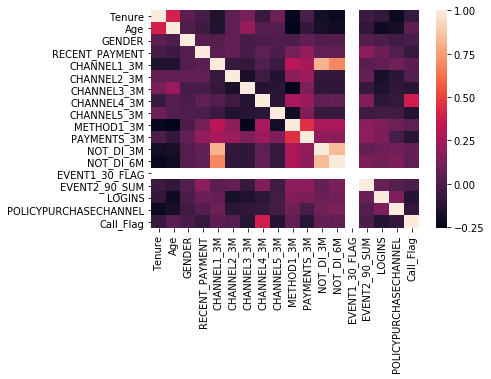

In [22]:
# Heatmap of correlation of features
corr = df_raw.corr()
sns.heatmap(corr)
plt.show()

# Build Model & Model Validation

In [23]:
# split train & test dataset
trainSize = int(0.75*(X.shape[0]))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=trainSize, random_state=24)

# Random Forest Model

In [24]:
score = make_scorer(roc_auc_score)
parameters = {'n_estimators':(10,15,20),
              'criterion':('gini','entropy'),
              'min_samples_split':(2,3,4),
              'min_samples_leaf':(1,2,3)}
rfc = RandomForestClassifier(random_state=42, warm_start=False, class_weight='balanced')
grid_obj = GridSearchCV(rfc, param_grid=parameters, scoring=score, verbose=1, n_jobs=4, cv=4)
grid_obj = grid_obj.fit(X_train, y_train)
rfc = grid_obj.best_estimator_

print('Train Dataset score {}'.format(rfc.score(X_train, y_train)))
print('Test Dataset score {}'.format(rfc.score(X_test, y_test)))

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   34.1s
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:   38.6s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Train Dataset score 0.9990828924162257
Test Dataset score 0.9597883597883597


In [25]:
cross_val_score(rfc, X_train, y_train, cv=4)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y wa

array([0.93961625, 0.93829367, 0.94055122, 0.93942244])

In [26]:
# confusion matrix
conf_mat = confusion_matrix(y_train, rfc.predict(X_train))
print(conf_mat)

[[21157    39]
 [    0 21329]]


In [27]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      7154
           1       0.92      1.00      0.96      7021

    accuracy                           0.96     14175
   macro avg       0.96      0.96      0.96     14175
weighted avg       0.96      0.96      0.96     14175



# GBDT Model

In [28]:
score = make_scorer(roc_auc_score)
parameters = {'loss':('deviance','exponential'),
              'learning_rate':(0.01,0.1,1.0),
              'min_samples_split':(2,3,4),
              'min_samples_leaf':(1,2,3)}
GBDT = GradientBoostingClassifier(random_state=42, warm_start=False)
grid_obj = GridSearchCV(GBDT, param_grid=parameters, scoring=score, verbose=1, n_jobs=4, cv=4)
grid_obj = grid_obj.fit(X_train, y_train)
GBDT = grid_obj.best_estimator_

print('Train Dataset score {}'.format(GBDT.score(X_train, y_train)))
print('Test Dataset score {}'.format(GBDT.score(X_test, y_test)))

Fitting 4 folds for each of 54 candidates, totalling 216 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 216 out of 216 | elapsed:  3.6min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Train Dataset score 0.8281011169900059
Test Dataset score 0.8026807760141094


In [29]:
print(classification_report(y_test, GBDT.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      7154
           1       0.78      0.84      0.81      7021

    accuracy                           0.80     14175
   macro avg       0.80      0.80      0.80     14175
weighted avg       0.80      0.80      0.80     14175



# KNN Model

In [30]:
parameters = {'n_neighbors':(5,10,15,20),
              'weights':('uniform','distance'),
              'p':(1,2)}

knn = KNeighborsClassifier()
grid_obj = GridSearchCV(knn, param_grid=parameters, scoring=score, verbose=1, n_jobs=4, cv=4)
grid_obj = grid_obj.fit(X_train, y_train)
knn = grid_obj.best_estimator_

print('Train Dataset score {}'.format(knn.score(X_train, y_train)))
print('Test Dataset score {}'.format(knn.score(X_test, y_test)))

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:   23.7s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Train Dataset score 0.9997883597883598
Test Dataset score 0.8428924162257495


In [31]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.69      0.82      7154
           1       0.76      1.00      0.86      7021

    accuracy                           0.84     14175
   macro avg       0.88      0.84      0.84     14175
weighted avg       0.88      0.84      0.84     14175



# Result Analysis: 

After comparing performance of three classifier below, the Random Forest performs best among three models.
Also, it's speed is faster than GBDT method.